/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Coupling map:


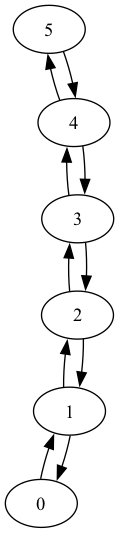

In [1]:
from spillover_effect_on_subsystem import (
    LocalSpilloverNoiseAerPass,
    circuit_context,
    numpy_to_hashable,
    noisy_backend,
)
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qiskit.transpiler import PassManager, CouplingMap
import numpy as np
import matplotlib.pyplot as plt
from rl_qoc.helpers.transpiler_passes import CausalConePass

num_qubits = 6
rotation_axes = ["rx", "rx", "rx", "rx", "rx", "rx"]
rotation_parameters = [Parameter(f"ϕ_{i}") for i in range(num_qubits)]
cm = CouplingMap.from_line(num_qubits, True)
print("Coupling map:")
cm.draw()

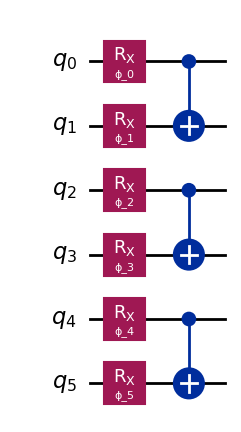

In [2]:
circuit = circuit_context(
    num_qubits, rotation_axes, rotation_parameters, coupling_map=cm
)
circuit.draw("mpl")

Parameter dictionary:
 {Parameter(ϕ_0): 4.665466064857704, Parameter(ϕ_1): 3.4958331672967256, Parameter(ϕ_2): 1.1607433119572852, Parameter(ϕ_3): 3.9246618340416872, Parameter(ϕ_4): 0.8148633976847353, Parameter(ϕ_5): 6.110646020345377}


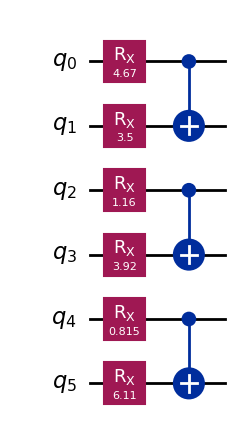

In [3]:
seed = 20983
np.random.seed(seed)
rotation_angles = np.random.uniform(0, 2 * np.pi, num_qubits)
# rotation_angles = np.array([0.0, 0.0, np.pi, 0., 0.0, 0.0])
param_dict = {theta: val for theta, val in zip(rotation_parameters, rotation_angles)}
print("Parameter dictionary:\n", param_dict)
circuit.assign_parameters(param_dict).draw("mpl")

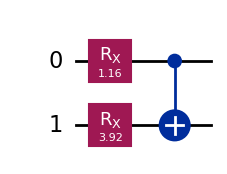

In [4]:
from rl_qoc.helpers import causal_cone_circuit

causal_cone_circuit(circuit.assign_parameters(param_dict), [2, 3])[0].draw("mpl")

Text(0.5, 1.0, 'Spillover rate matrix')

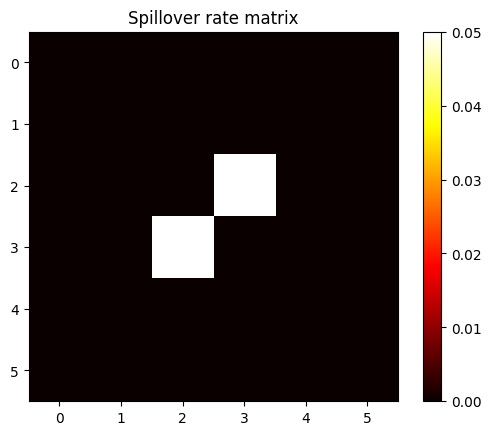

In [5]:
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
gamma_matrix[0, 1] = 0.0  # γ_0->1
gamma_matrix[0, 3] = 0.0  # γ_0->3
gamma_matrix[1, 2] = 0.0  # γ_1->2
gamma_matrix[2, 2] = 0.0  # γ_2->2
gamma_matrix[2, 3] = 0.05  # γ_2->3
gamma_matrix[3, 2] = 0.05  # γ_3->2
gamma_matrix[4, 3] = 0.0  # γ_4->3
gamma_matrix[5, 4] = 0.0  # γ_5->4
# gamma_matrix = 0.05 * np.round(np.random.rand(num_qubits, num_qubits), 3)

# Generate another gamma matrix based on coupling map defined above
# gamma_matrix = 0.0 * np.eye(num_qubits)
# for edge in cm.get_edges():
#     gamma_matrix[edge[0], edge[1]] = 0.05


# Display gamma matrix with imshow plot for better visualization
plt.imshow(gamma_matrix, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Spillover rate matrix")

# Display gamma matrix as weights in a directed graph
# import networkx as nx
#
# G = nx.DiGraph(gamma_matrix)
# pos = nx.spring_layout(G)
# nx.draw(G, None, with_labels=True, node_size=1000, node_color="skyblue", font_size=10)
# labels = nx.get_edge_attributes(G, "weight")
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
# plt.title("Spillover rate matrix as directed graph")

In [6]:
gamma_matrix

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.05, 0.  , 0.  ],
       [0.  , 0.  , 0.05, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

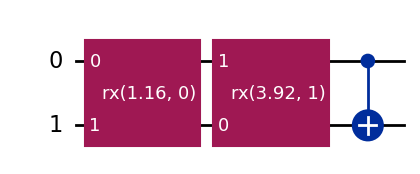

In [7]:
spillover_pass = LocalSpilloverNoiseAerPass(
    spillover_rate_matrix=numpy_to_hashable(gamma_matrix),
    target_subsystem=(2, 3),
)
causal_cone_pass = CausalConePass((2, 3))
pm = PassManager([spillover_pass, causal_cone_pass])
qc_noisy = causal_cone_circuit(circuit.assign_parameters(param_dict), [2, 3])[0]
qc_noisy = circuit.assign_parameters(param_dict)
qc_noisy = pm.run(qc_noisy)
qc_noisy.draw("mpl")

In [8]:
qc_noisy.qubits

[Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3)]

In [9]:
qc_noisy.data

[CircuitInstruction(operation=Instruction(name='unitary', num_qubits=2, num_clbits=0, params=[array([[0.83625892+0.j        , 0.        -0.54833478j,
        0.        +0.j        , 0.        +0.j        ],
       [0.        -0.54833478j, 0.83625892+0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.83625892+0.j        , 0.        -0.54833478j],
       [0.        +0.j        , 0.        +0.j        ,
        0.        -0.54833478j, 0.83625892+0.j        ]])]), qubits=(Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3)), clbits=()), CircuitInstruction(operation=Instruction(name='unitary', num_qubits=2, num_clbits=0, params=[array([[-0.38160732+0.j        ,  0.        -0.92432454j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        -0.92432454j, -0.38160732+0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,

In [10]:
backend = noisy_backend(
    circuit.assign_parameters(param_dict),
    gamma_matrix,
    target_subsystem=(2, 3),
)

In [11]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': 'ad418febff6342a3b63c8a46a6402f11',
   'operations': ['rx(1.16, 0)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0, 1],
      'params': [array([[0.99519043+0.j       , 0.        -0.0979592j,
               0.        +0.j       , 0.        +0.j       ],
              [0.        -0.0979592j, 0.99519043+0.j       ,
               0.        +0.j       , 0.        +0.j       ],
              [0.        +0.j       , 0.        +0.j       ,
               0.99519043+0.j       , 0.        -0.0979592j],
              [0.        +0.j       , 0.        +0.j       ,
               0.        -0.0979592j, 0.99519043+0.j       ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(0, 1)]},
  {'type': 'qerror',
   'id': '6848f104cbd0476d9aab605cb7cfb70c',
   'operations': ['rx(3.92, 1)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0, 1],
      'params': [array([[0.99957899+0.j        , 0.        +0.j        ,
               0.      

In [12]:
from qiskit.transpiler import generate_preset_pass_manager

full_pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
custom_translation_pass = PassManager(
    [spillover_pass, causal_cone_pass] + full_pm.translation._tasks[0]
)
full_pm.translation = custom_translation_pass

In [13]:
full_pm.translation._tasks

[[<spillover_effect_on_subsystem.LocalSpilloverNoiseAerPass at 0x15a9f9690>,

In [14]:
print("Rotation angles:", rotation_angles)

Rotation angles: [4.66546606 3.49583317 1.16074331 3.92466183 0.8148634  6.11064602]


In [15]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': 'f14df93c894f4f68b2614f94007b304c',
   'operations': ['h'],
   'instructions': [[{'name': 'id', 'qubits': [0]}],
    [{'name': 'x', 'qubits': [0]}],
    [{'name': 'y', 'qubits': [0]}],
    [{'name': 'z', 'qubits': [0]}]],
   'probabilities': [0.9925000000000002,
    0.0025000000000000005,
    0.0025000000000000005,
    0.0025000000000000005]},
  {'type': 'qerror',
   'id': 'f14df93c894f4f68b2614f94007b304c',
   'operations': ['x'],
   'instructions': [[{'name': 'id', 'qubits': [0]}],
    [{'name': 'x', 'qubits': [0]}],
    [{'name': 'y', 'qubits': [0]}],
    [{'name': 'z', 'qubits': [0]}]],
   'probabilities': [0.9925000000000002,
    0.0025000000000000005,
    0.0025000000000000005,
    0.0025000000000000005]},
  {'type': 'qerror',
   'id': 'f14df93c894f4f68b2614f94007b304c',
   'operations': ['s'],
   'instructions': [[{'name': 'id', 'qubits': [0]}],
    [{'name': 'x', 'qubits': [0]}],
    [{'name': 'y', 'qubits': [0]}],
    [{'name': 'z', 'qub

In [16]:
from qiskit.quantum_info import Operator

Operator(qc_noisy)

Operator([[-0.31912253+0.j        ,  0.        +0.20924857j,
            0.        -0.77297464j, -0.50683929+0.j        ],
          [-0.50683929+0.j        ,  0.        -0.77297464j,
            0.        +0.20924857j, -0.31912253+0.j        ],
          [ 0.        -0.77297464j, -0.50683929+0.j        ,
           -0.31912253+0.j        ,  0.        +0.20924857j],
          [ 0.        +0.20924857j, -0.31912253+0.j        ,
           -0.50683929+0.j        ,  0.        -0.77297464j]],
         input_dims=(2, 2), output_dims=(2, 2))


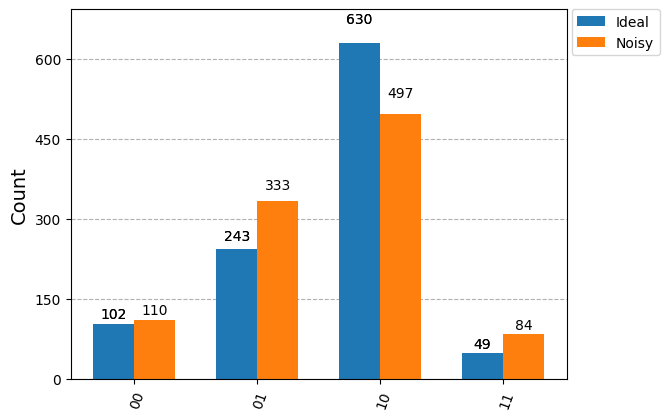

In [17]:
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

ideal_backend = AerSimulator()

ideal_result = ideal_backend.run(qc_noisy.measure_all(inplace=False)).result()
noisy_result = backend.run(qc_noisy.measure_all(inplace=False)).result()

ideal_counts = ideal_result.get_counts()
noisy_counts = noisy_result.get_counts()

plot_histogram([ideal_counts, noisy_counts], legend=["Ideal", "Noisy"])

In [18]:
# Compute fidelities
from qiskit.quantum_info import state_fidelity, average_gate_fidelity

qc_noisy_ideal_state = qc_noisy.copy()
qc_noisy_state = qc_noisy.copy()
# qc_noisy_ideal_state.save_statevector()
qc_noisy_ideal_state.save_unitary()
# qc_noisy_state.save_statevector()
qc_noisy_state.save_unitary()

# ideal_state = ideal_backend.run(qc_noisy_ideal_state).result().get_statevector()
# noisy_state = backend.run(qc_noisy_state).result().get_statevector()
ideal_unitary = ideal_backend.run(qc_noisy_ideal_state).result().get_unitary()
noisy_unitary = backend.run(qc_noisy_state).result().get_unitary()

In [19]:
output_fidelity = average_gate_fidelity(ideal_unitary, noisy_unitary)
output_fidelity

0.9871388449062639

In [20]:
from qiskit import QuantumRegister
from rl_qoc.helpers.circuit_utils import get_gate


# Add here custom ansatz CX gate


# def apply_parametrized_circuit(
#     qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
# ):
#     """
#     Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
#     This function is used to run the QuantumCircuit instance on a Runtime backend
#     :param qc: Quantum Circuit instance to add the gate on
#     :param params: Parameters of the custom Gate
#     :param q_reg: Quantum Register formed of target qubits
#     :return:
#     """
#     target = kwargs["target"]
#     my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
#     optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
#     # optimal_params = np.pi * np.zeros(len(params))
#     new_params = [optimal_params[i] + params[i] for i in range(len(params))]

#     my_qc.u(
#         new_params[0],
#         -np.pi/2,
#         np.pi/2,
#         q_reg[0],
#     )
#     my_qc.u(
#         0.,
#         new_params[1],
#         new_params[2],
#         q_reg[0],
#     )
#     my_qc.u(
#         *new_params[3:6],
#         q_reg[1],
#     )

#     my_qc.rzx(new_params[-1], q_reg[0], q_reg[1])

#     qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

def apply_parametrized_circuit(
    qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :param params: Parameters of the custom Gate
    :param q_reg: Quantum Register formed of target qubits
    :return:
    """
    target = kwargs["target"]
    my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    # optimal_params = np.pi * np.zeros(len(params))
    new_params = [optimal_params[i] + params[i] for i in range(len(params))]

    my_qc.u(
        *new_params[:3],
        q_reg[0],
    )
    my_qc.u(
        *new_params[3:6],
        q_reg[1],
    )

    my_qc.rzx(new_params[-1], q_reg[0], q_reg[1])

    qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

In [21]:
# Define the environment
from gymnasium.spaces import Box
from rl_qoc import (
    QEnvConfig,
    ExecutionConfig,
    ContextAwareQuantumEnvironment,
    RescaleAndClipAction,
)
from rl_qoc.environment.configuration.backend_config import QiskitConfig
from arbitrary_angle_spillover_env import (
    ArbitraryAngleSpilloverEnv,
)

env_metadata = {
    "γ": gamma_matrix,
    "target_subsystem": (2, 3),
    "rotation_axes": rotation_axes,
    "num_qubits": num_qubits,
    "rotation_parameters": rotation_parameters,
    "seed": seed,
}
action_space = Box(low=-0.5, high=0.5, shape=(7,), dtype=np.float32)
target = {"gate": "cnot", "physical_qubits": [2, 3]}

backend_config = QiskitConfig(
    apply_parametrized_circuit,
    backend=backend,
    skip_transpilation=False,
    parametrized_circuit_kwargs={"target": target, "backend": backend},
    pass_manager=full_pm,
)
q_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=32,
        n_reps=[5,],
        n_shots=100,
        sampling_paulis=1000,
        c_factor=1,
        seed=seed + 6,
        n_reps_mode="sequential",
        control_flow_enabled=False,
    ),
    reward="fidelity",
    env_metadata=env_metadata,
)


In [22]:
# Constructing single angle spillover env

from single_angle_spillover_env import OneParamAngleSpilloverEnv

one_env = OneParamAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubit=2,
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)

Observation Vals for Agent: [-1.  -0.5  0.   0.5  1. ]
Observation Vals for Env: [0.         0.78539816 1.57079633 2.35619449 3.14159265]


In [23]:
rescaled_q_env = RescaleAndClipAction(one_env, min_action=-1., max_action=1.)

In [24]:
_, _ = one_env.reset(debug_obs=np.array([np.pi]))

Sampled angles:  [0.         0.         3.14159265 0.         0.         0.        ]
Environment Observation: [1.]


Number of repetitions: 1
Starting simulation benchmark...


Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9950753362380551
Reward (avg): 0.9950753362380551 Std: 0.0
Number of repetitions: 5
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9950753362380551
Reward (avg): 0.9378921202748728 Std: 0.0
Number of repetitions: 9
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9950753362380551
Reward (avg): 0.8176370356758358 Std: 0.0
Number of repetitions: 13
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9950753362380551
Reward (avg): 0.6617249344919631 Std: 0.0
Number of repetitions: 17
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9950753362380551
Reward (avg): 0.5027584735237126 Std: 0.0
Number of repetitions: 21
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9950753362380551
Reward (avg): 0.3687131

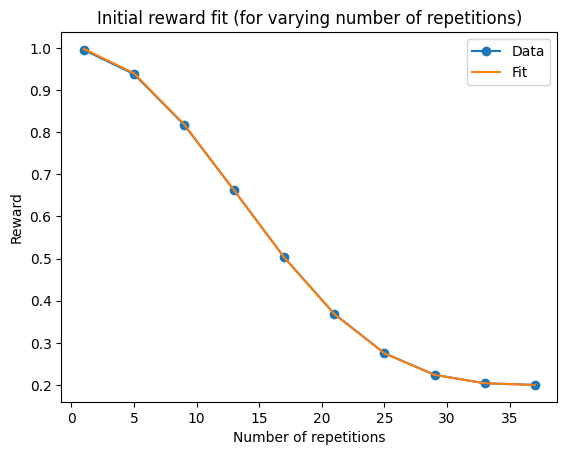

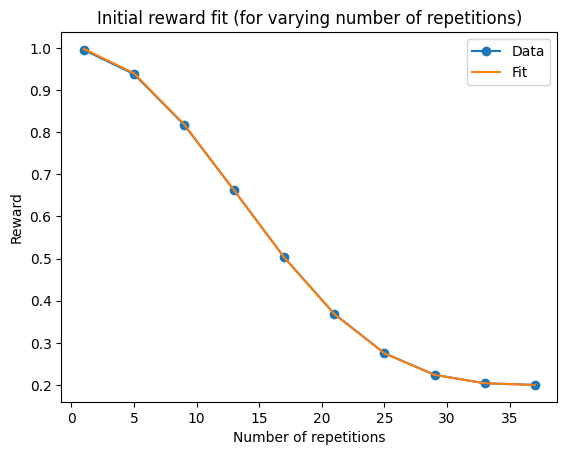

In [25]:
one_env.initial_reward_fit(
    np.zeros((1, 7)),
    ExecutionConfig(
        sampling_paulis=1000,
        n_shots=100,
        n_reps=list(
            range(1, 40, 4),
        ),
        dfe_precision=None,
        seed=q_env_config.seed,
        control_flow_enabled=False,
    ),
    update_fit_params=False,
    reward_method="fidelity",
)

In [26]:
baseline_reward = []

one_env.clear_history()
for set_obs in one_env.discrete_obs_vals_angles:
    # _obs, info = alt_q_env.reset(debug_obs=np.array([1.]))
    _obs, info = one_env.reset(debug_obs=np.array([set_obs]))
    zero_action = np.zeros((one_env.batch_size,) + one_env.action_space.shape)
    print(zero_action.shape)
    obs, reward, terminated, truncated, info = one_env.step(zero_action)
    baseline_reward.append(np.mean(reward))
    print(f"discrete reward history: {one_env.discrete_reward_history}")

Sampled angles:  [0. 0. 0. 0. 0. 0.]
Environment Observation: [-1.]
(32, 7)
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities (per Cycle):  1.0
Reward (avg): 1.0 Std: 0.0
obs: [-1.]
reward: [6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6.]
discrete reward history: [[6. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
Sampled angles:  [0.         0.         0.78539816 0.         0.         0.        ]
Environment Observation: [-0.5]
(32, 7)
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9996916144962891
Reward (avg): 0.995998589802006 Std: 0.0
obs: [-0.5]
reward: [2.39778693 2.39778693 2.39778693 2.39778693 2.39778693 2.39778693
 2.39778693 2.39778693 2.39778693 2.39778693 2.39778693 2.39778693
 2.39778693 2.39778693 2.39778693 2.39778693 2.39778693 2.39778693
 2.39778693 2.39778693 2.39778693 2.3977869

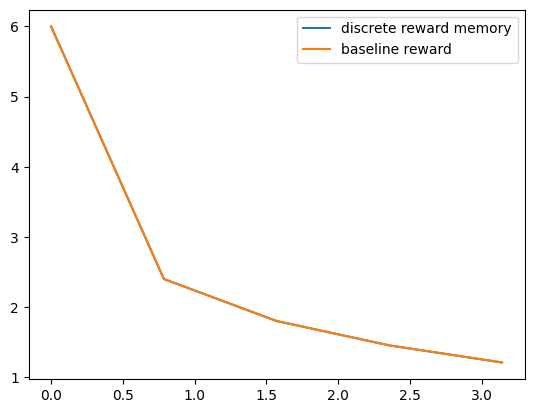

In [27]:
plt.plot(one_env.discrete_obs_vals_angles, one_env.discrete_reward_history[0], label='discrete reward memory')
plt.plot(one_env.discrete_obs_vals_angles, baseline_reward, label='baseline reward')
plt.legend()
plt.show()

In [28]:
# PPO Details

from ppo_cleanrl import PPO_CleanRL

one_env = OneParamAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubit=2,
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)

agent_config = {
    "exp_name": "Test PPO CleanRL",
    "seed": 1,
    "torch_deterministic": True,
    "cuda": False,
    "track": False,
    "wandb_project_name": "Context Aware Calibrations",
    "wandb_entity": None,
    "save_model": True,
    "plot_real_time": True,
    "num_prints": 5,
    "total_updates": 400,
    "learning_rate": 3e-3,
    "num_envs": 32,
    "num_steps": 1,
    "anneal_lr": True,
    "anneal_num_updates": 1600,
    "exp_anneal_lr": False,
    "exp_update_time": 100,
    "plateau_lr": 1e-6,
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "num_minibatches": 4,
    "update_epochs": 8,
    "norm_adv": True,
    "activation_function_str": "elu",
    "use_combined_networks": False,
    "layer_size": 64,
    "clip_coef": 0.2,
    "clip_vloss": True,
    "ent_coef": 0.0,
    "vf_coef": 0.5,
    "max_grad_norm": 0.5,
    "target_kl": None,
    "robust_ppo": False,
}

# alt_q_env.clear_history()
rescaled_q_env = RescaleAndClipAction(one_env, min_action=-1., max_action=1.)
ppo_agent = PPO_CleanRL(agent_config, rescaled_q_env)

Observation Vals for Agent: [-1.  -0.5  0.   0.5  1. ]
Observation Vals for Env: [0.         0.78539816 1.57079633 2.35619449 3.14159265]


In [29]:
# Testing the optimal policy in advance

single_n_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=32,
        n_reps=[1,],
        n_shots=1000,
        sampling_paulis=1000,
        c_factor=1,
        seed=seed + 6,
        n_reps_mode="sequential",
        control_flow_enabled=False,
    ),
    reward="fidelity",
    env_metadata=env_metadata,
)

single_n_q_env = OneParamAngleSpilloverEnv(
    single_n_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubit=2,
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)

Observation Vals for Agent: [-1.  -0.5  0.   0.5  1. ]
Observation Vals for Env: [0.         0.78539816 1.57079633 2.35619449 3.14159265]


In [26]:
# Testing fidelity of agents

import copy
import torch

rewards = []

# action_test = copy.deepcopy(actions)
o_vals = one_env.discrete_obs_vals_angles
ana_sum = -o_vals * 0.05 # gamma value
ana_scaled = ana_sum / 0.5 # env action space bounds
# ana_scaled = np.zeros_like(ana_sum)

for i, sample_obs in enumerate(ppo_agent.env.unwrapped.discrete_obs_vals_angles):
    next_obs = torch.Tensor(np.tile(sample_obs, (ppo_agent.num_envs, 1)))

    _obs, info = ppo_agent.env.unwrapped.reset(seed=ppo_agent.seed, debug_obs=np.array([sample_obs]))
    # act = action_test[i]
    act = np.zeros(7)
    act[0] = 0.# ana_scaled[i]
    act[1] = 0.
    act[2] = 0.
    act[3] = ana_scaled[i]
    act[4] = 0.
    act[5] = 0.
    act[6] = 0.
    
    print(f"action: {act}")
    batch_action = np.tile(act, (ppo_agent.env.unwrapped.batch_size, 1))
    obs, reward, terminated, truncated, info = ppo_agent.env.step(batch_action)
    rewards.append(np.mean(reward))

NameError: name 'ppo_agent' is not defined

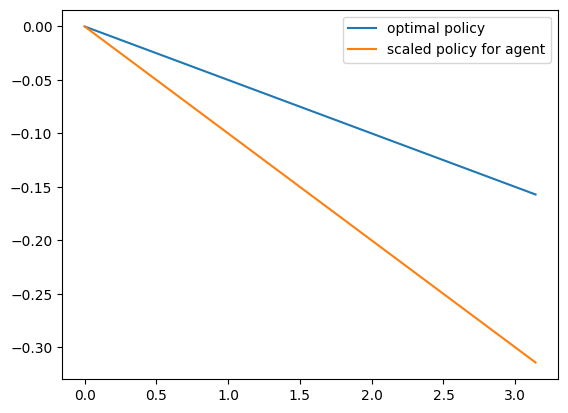

In [40]:
plt.plot(o_vals, ana_sum, label='optimal policy')
plt.plot(o_vals, ana_scaled, label='scaled policy for agent')
plt.legend()
plt.show()

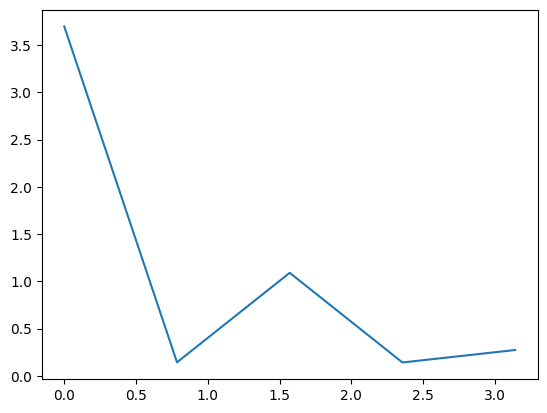

In [41]:
plt.plot(o_vals, rewards)
plt.show()